
# Tuberculosis Simulation Notebook

This notebook demonstrates how to create and run simulations for tuberculosis (TB) using the `tbsim` and `starsim` libraries. The simulations will model the spread and impact of TB over time on a population.


## Packages

The code in this section imports the `starsim` package, which provides the capabilities to create and run simulations.
Note that while `TBsim` enables some functionality, the full capabilities are provided by `starsim`.


In [72]:

# Import necessary libraries
import tbsim as mtb
import starsim as ss
import matplotlib.pyplot as plt


# The steps

As suggested by the starsim 'Getting Started' tutorial (https://docs.idmod.org/projects/starsim/en/latest/tutorials/tut_intro.html) we will proceed with the most common tasks for modeling infectious diseases, in our case, TB:

1. Defining the tuberculosis, simulator and additional core component's parameters 
2. Running the simulation 
3. Plotting the results

<h1 style="color: lightblue; "> Defining the tuberculosis, simulator and additional core component's parameters </h1>

In this case, in order to make our code reusable  we will encapsulate all our preparation steps in the following function, `make_tb`, sets up and returns a simulation for tuberculosis with user specified parameters, default values are generally specified as part of the __init__ method for each class).

#### People:
- Creates a population of 1,000 agents using the People class from the starsim (aliased as ss) library.

#### TB Disease
- Defines the disease parameters for TB:
    - beta: Transmission rate.
    - init_prev: Initial prevalence of TB (25%).
- Initializes the TB model with these parameters using the tbsim library (aliased as mtb).

#### Network
- Defines the network parameters:
    - n_contacts: Number of contacts per agent, following a Poisson distribution with a mean (lambda) of 5.
    - dur: Duration of contact (0 means end after one timestep).
- Initializes a random network with these parameters.

#### Demographics

The demographics section sets up two demographic processes for the simulation: pregnancy and death rates. These, define and incorporate key demographic events into the simulation model:

- **Pregnancy**: Adds new agents to the population at a rate of 15 per 1,000 people. (TODO: Verify if this is done every time every step or if this is a one time event at set_prognoses)
- **Deaths**: Removes agents from the population at a rate of 10 per 1,000 people. (same question as above)

This setup ensures the simulation realistically accounts for population changes over time due to births and deaths.

#### Simulation Parameters and Initialization

This part of the code defines the parameters for the simulation and initializes it using these parameters:

1. **Defining Simulation Parameters**:
    - **`dt = 7/365`**: This defines the time step (`dt`) for the simulation. Here, `7/365` represents a weekly time step,  the simulation progresses in weekly increments.
    - **`start = 1990`**: This sets the starting year of the simulation to 1990.
    - **`end = 2000`**: This sets the ending year of the simulation to 2000.

2. **Initializing the Simulation**:
    - **`ss.Sim`**: This is a class from the `starsim` package used to create a simulation object.
    - **Parameters**:
        - **`people=pop`**: Specifies the population object created earlier.
        - **`networks=net`**: Specifies the network object that describes how agents are connected.
        - **`diseases=tb`**: Specifies the TB disease model initialized earlier.
        - **`pars=sim_pars`**: Passes the simulation parameters defined above.
        - **`demographics=dems`**: Specifies the list of demographic events (pregnancy and death rates).

3. **Setting Verbosity**:
    - This line adjusts how frequently the simulation prints its status updates.
    - **`sim.pars.dt / 5`**: By dividing the time step (`dt`) by 5, the simulation is set to print updates every 5 years. This ensures that the status updates are less frequent but still provide periodic insights into the simulation's progress.

4. **Returning the Simulation Object**:
    - This returns the initialized simulation object so that it can be run or further interacted with outside of the `make_tb` function.



In [73]:
# Define the function to create a tuberculosis simulation
def make_tb():
    # --------------- People ----------
    initial_population_size = 1000
    pop = ss.People(n_agents=initial_population_size)
    
    # --------------- TB disease --------
    tb_pars = dict(  # Disease parameters
        beta = 0.001, 
        init_prev = 0.25,
        )
    tb = mtb.TB(tb_pars) # Initialize

    # --------------- Network ---------
    net_pars = dict(    # Network parameters
        n_contacts=ss.poisson(lam=5),
        dur = 0, # End after one timestep
        )
    net = ss.RandomNet(net_pars)  # Initialize a random network

    # --------------- Demographics --------
    dems = [
        ss.Pregnancy(pars=dict(fertility_rate=15)), # Per 1,000 people
        ss.Deaths(pars=dict(death_rate=10)), # Per 1,000 people
    ]

    # --------------- simulation -------
    sim_pars = dict(    # define simulation parameters
        dt = 7/365,
        start = 1990,
        end = 2000,
        )
    sim = ss.Sim(people=pop, networks=net, diseases=tb, pars=sim_pars, demographics=dems)   # initialize the simulation
    sim.pars.verbose = sim.pars.dt / 5      # Print status every 5 years instead of every 10 steps
    return sim



<h1 style="color: orange; "> Run the Simulation </h1>

We will now create and run the first simulation using the `make_tb` function with default parameters.


In [74]:

# Create and run the first simulation
sim = make_tb()  # Create the simulation - running make_tb returns a simulation of a type ss.Sim (from starsim library) therefore we can use all the methods of the ss.Sim class
sim.run()        # Run the simulation 


c:\git\starsim\starsim\parameters.py:296: RuntimeWarning: 
  ss.warn(warnmsg)


Initializing sim with 1000 agents
  Running 1990.0 ( 0/521) (0.28 s)  ———————————————————— 0%
  Running 1995.0 (260/521) (1.92 s)  ••••••••••—————————— 50%
  Running 2000.0 (520/521) (3.44 s)  •••••••••••••••••••• 100%



Sim(n=1000; networks=randomnet; demographics=pregnancy, deaths; diseases=tb)

<h1> The results </h1>

Lets first take a look at which data was generated,  please refer to https://docs.idmod.org/projects/starsim/en/latest/api/_autosummary/starsim.results.Result.html for more information 

RECORDED RESULTS: 
 ['n_susceptible', 'n_infected', 'prevalence', 'new_infections', 'cum_infections', 'n_latent_slow', 'n_latent_fast', 'n_active_presymp', 'n_active_smpos', 'n_active_smneg', 'n_active_exptb', 'new_deaths', 'cum_deaths']


Text(0.5, 1.0, 'The most basic sample \n TB Prevalence \n (raw data)')

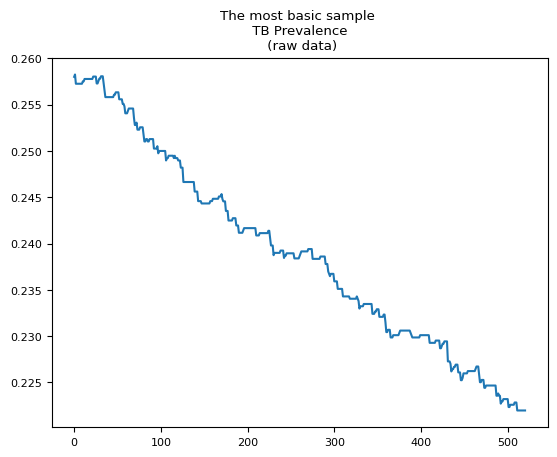

In [75]:
tbr = sim.diseases['tb'].results

print("RECORDED RESULTS: \n",tbr.keys())

plt.plot(range(0,len(tbr['prevalence'])),tbr['prevalence'])
plt.title("The most basic sample \n TB Prevalence \n (raw data)")



<h1 style="color: orange; ">Plotting</h1>
<p>Once you get familiar with the available data in the results object, you can proceed to plot your results using your favorite method.</p>
<h3 style="color: lightblue; ">1: Using the starsim library</h3>
<p>Plot the results of the simulation - inherited from the starsim library which is available under the diseases attribute of the simulation.</p>
<h3 style="color: lightblue; ">2: Using the tbsim library</h3>
<p>tbsim - tb - exposes also a plot method (you can also use it to get an idea of how you can implement your own plotting function).</p>
<h3 style="color: lightblue; ">3: Use your own plotting function</h3>
<p>Using only the data from the collection of results dataframes, implement your own plotting method.</p>


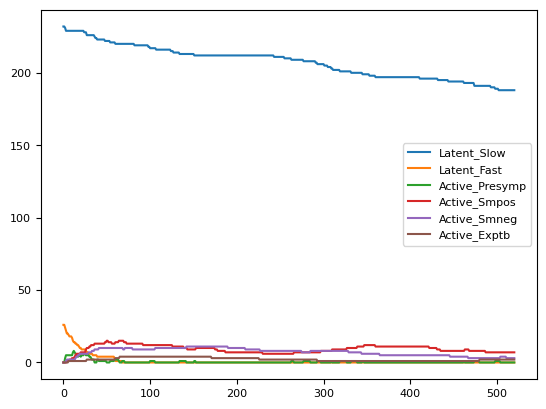

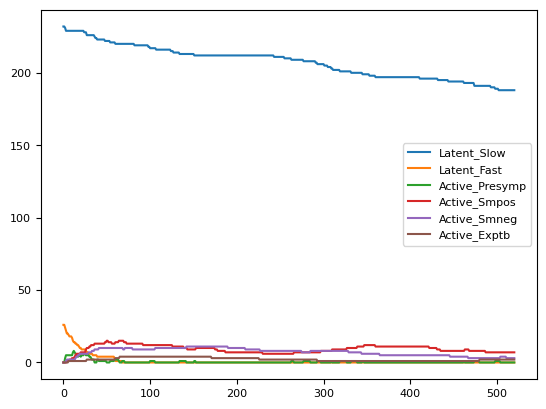

In [76]:
# Method 1: ---------------------------------
sim.diseases['tb'].plot()   # Plot the results of the simulation - inherited from the starsim library which is available under the diseases attribute of the simulation


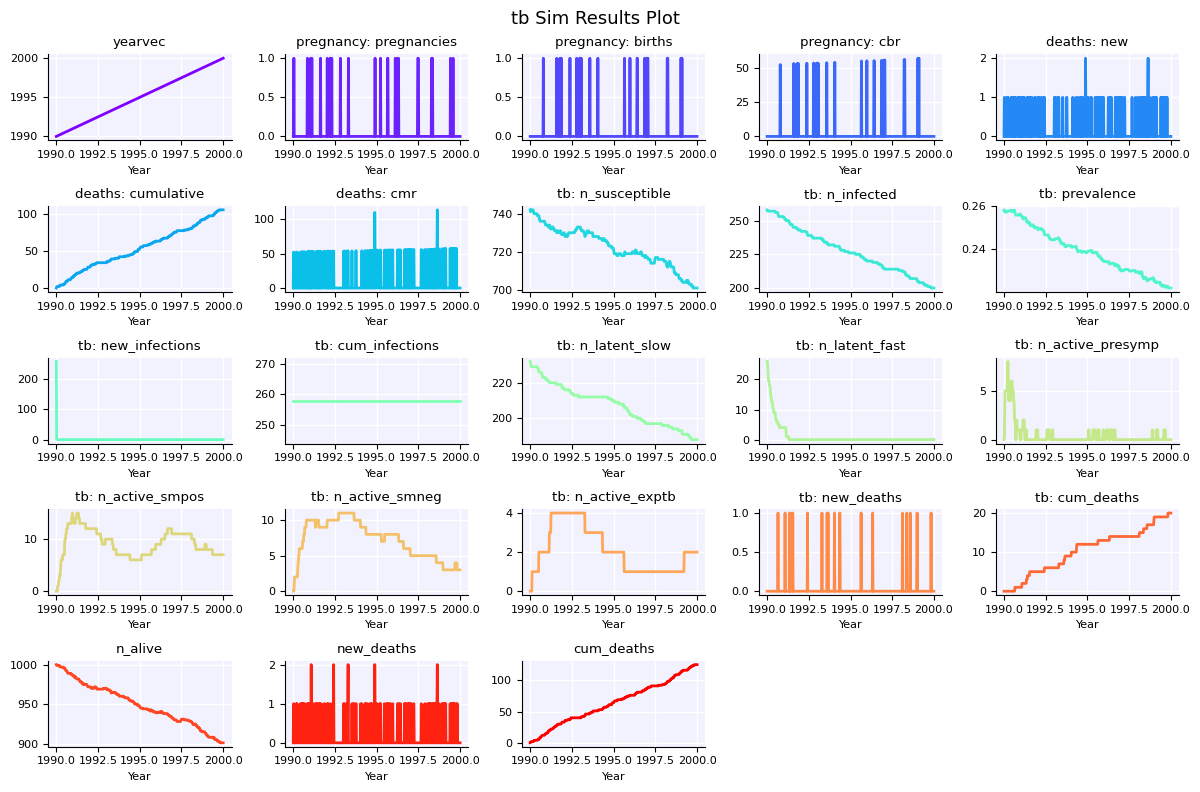

In [77]:

# Method 2: --------------------------------------------
mtb.plot_sim(sim)           # Now we plot using the plot_sim method implemented 'only' within the TB library 
plt.show()


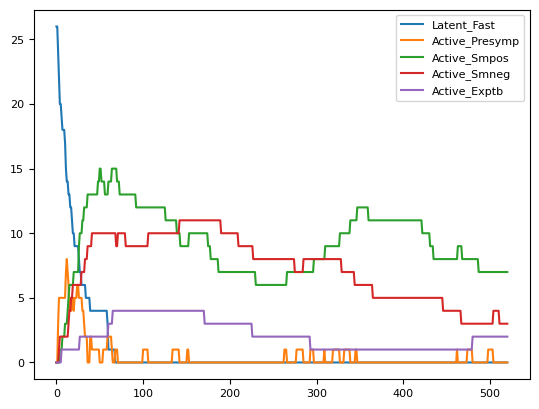

In [78]:

# Method 3:  ------------------------------------------------------
fig = plt.figure()
simulation_results = sim.results['tb']
for rkey in [ 'latent_fast', 'active_presymp', 'active_smpos', 'active_smneg', 'active_exptb']:
    plt.plot(simulation_results['n_'+rkey], label=rkey.title())
plt.legend()



## Define a Simplified Tuberculosis Simulation Function

The following function, `make_tb_simplified`, allows for setting custom parameters for the simulation, such as the number of agents, start and end years, and the time step (`dt`) using a more simplified format.


In [79]:

# Define another function to create a tuberculosis simulation with different parameters
def make_tb_simplified(agents=1000, start=2000, end=2020, dt=7/365):
    pop = ss.People(n_agents=agents)
    tb = mtb.TB(dict(beta = 0.001, init_prev = 0.25))
    net = ss.RandomNet(dict(n_contacts=ss.poisson(lam=5), dur = 0))
    dems = [ss.Pregnancy(pars=dict(fertility_rate=15)), ss.Deaths(pars=dict(death_rate=10))]
    sim = ss.Sim(people=pop, networks=net, diseases=tb, pars=dict(dt = dt, start = start, end = end), demographics=dems)
    sim.pars.verbose = sim.pars.dt / 5
    return sim



## Run the Second Simulation using a simplified approach

Next, we will create and run a second simulation using the `make_tb_simplified` function with custom parameters to see how different settings affect the simulation outcome.


c:\git\starsim\starsim\parameters.py:296: RuntimeWarning: 
  ss.warn(warnmsg)


Initializing sim with 1500 agents
  Running 2000.0 ( 0/1041) (0.12 s)  ———————————————————— 0%
  Running 2005.0 (260/1041) (1.86 s)  •••••——————————————— 25%
  Running 2010.0 (520/1041) (3.46 s)  ••••••••••—————————— 50%
  Running 2015.0 (780/1041) (4.92 s)  •••••••••••••••————— 75%
  Running 2020.0 (1040/1041) (6.50 s)  •••••••••••••••••••• 100%



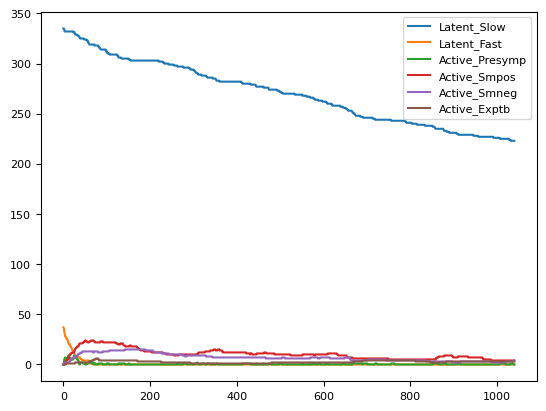

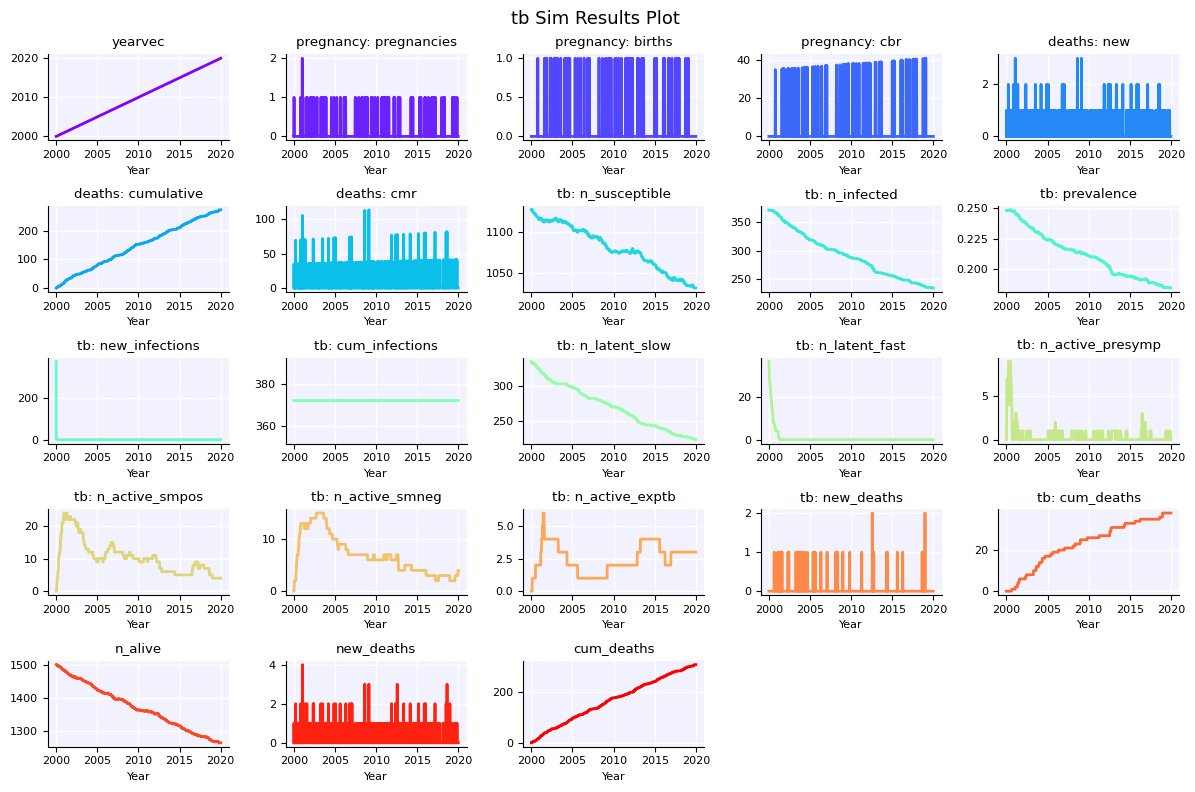

In [80]:

# Create and run the second simulation with different parameters
sim_tb = make_tb_simplified(agents=1500, start=2000, end=2020, dt=7/365)
sim_tb.run()
sim_tb.diseases['tb'].plot()
mtb.plot_sim(sim_tb)
plt.show()
